In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import scipy.stats
from matplotlib.ticker import MaxNLocator
import json
from collections import Counter
from experiment.metrics import compute_performance
from matplotlib.lines import Line2D
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
%matplotlib inline
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from matplotlib import rc

In [2]:
def find_files(res_dir, agent):
    ram = []
    time = []
    best_param = Counter()
    acc = []
    for f in os.listdir(res_dir):
        f_path = os.path.join(res_dir, f)
        if agent in f:
            output = pickle.load(open(f_path, 'rb'))
            ram.append(output['ram'])
            time.append(output['time'])
            param_freeze = [tuple(sorted(i.items())) for i in output['best_params']]
            best_param.update(param_freeze)
            acc.append(output['acc_array'])
    if acc:
        return np.array(ram), np.array(time), best_param, np.vstack(acc)
    else:
        return None, None, None,None

In [3]:
def avg_acc(acc):
    def helper(task_acc):
        ret = []
        for i in range(task_acc.shape[0]):
            ret.append(np.mean(task_acc[i, 0:i + 1]))
        return ret
    tmp = []
    for i in range(acc.shape[0]):
        k = acc[i]
        tmp.append(helper(k))
    return np.array(tmp)

## Trick Plot

In [119]:
def trick_plot(file_name, legend, save, trick_names, name_match, agents, mem,dataset):
    tmp_dict = {}
    acc_data = []
    trick_data = []
    mem_data = []
    agent_data = []
    for agent in agents:
        for m in mem:
            file_path = 'result/{}/{}/'.format(dataset, 'nc')
            ram, time, best_param, acc = find_files(file_path, agent+'_'+m)
            end_acc = acc[:, -1, :]
            avg_end_acc = np.mean(end_acc, axis=1) *100
            n = avg_end_acc.shape[0]
            acc_data += (avg_end_acc.tolist())
            trick_data += ['N/A']*n
            mem_data += [m]*n
            if agent == 'AGEM':
                agent_name = 'A-GEM'
            else:
                agent_name = agent
            agent_data += [agent_name]*n
            for trick in trick_names:
                file_path = 'result/{}/{}/{}'.format(dataset, 'nc', trick)
                ram, time, best_param, acc = find_files(file_path, agent+'_'+m)
                end_acc = acc[:, -1, :]
                avg_end_acc = np.mean(end_acc, axis=1)*100
                n = avg_end_acc.shape[0]
                #print(trick,agent, m)
                #print(np.mean(avg_end_acc))
                #avg_end_acc, avg_end_fgt, avg_acc, avg_bwtp, avg_fwt = compute_performance(acc)
                #print(avg_end_acc)
                acc_data += (avg_end_acc.tolist())
                trick_data += [name_match[trick]]*n
                mem_data += [m]*n
                agent_data += [agent_name]*n
    tmp_dict['data'] = acc_data
    tmp_dict['Trick'] = trick_data
    tmp_dict['Memory Size'] = mem_data
    tmp_dict['Method'] = agent_data
    data_preproc = pd.DataFrame(tmp_dict) 
    #with sns.plotting_context("paper", font_scale=1.5):
    g = sns.catplot(x="Memory Size", y="data", col='Method',hue="Trick", kind="bar", data=data_preproc, legend=legend, legend_out=True)
    g.set_ylabels('Accuracy(%)')
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=7, fontsize='medium')
    g.fig.subplots_adjust(top=0.8)
    if save:
        g.fig.savefig(file_name, format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

In [120]:
sns.set_theme(context='paper', style='darkgrid', palette='deep', font='sans-serif', font_scale=1.5)

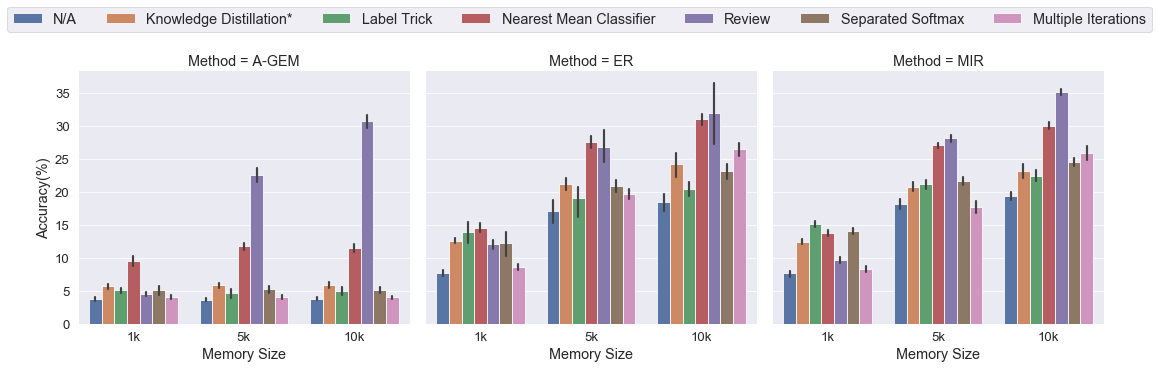

In [124]:
trick_names = ['kd_trick', 'labels_trick', 'nmc_trick','review_trick', 'separated_softmax', 'mi_trick']
agents = ['AGEM', 'ER', 'MIR']
mem = ['1k', '5k', '10k']
name_match = {'mi_trick':"Multiple Iterations" ,'kd_trick': 'Knowledge Distillation*', 'labels_trick': "Label Trick", 'review_trick': 'Review', 'separated_softmax': "Separated Softmax", 'nmc_trick': "Nearest Mean Classifier", 'rp_trick': 'Ratio Preserving'}
trick_plot(file_name='cifar_trick.pdf', legend=False, save=True, dataset='cifar100', trick_names=trick_names, name_match=name_match, agents=agents, mem=mem)
#trick_plot(file_name='mini_trick.pdf', legend=False, save=True, dataset='mini_imagenet', trick_names=trick_names, name_match=name_match, agents=agents, mem=mem)

## Acc Plot - all mem

In [17]:
def acc_plot_all_mem(file_name='cifar_trick.pdf', save=True, dataset='cifar100', 
                     agents=[], mem=[], task=18, cl_type='nc', print_name=[]):
    tmp_dict = {}
    x_data = []
    acc_data = []
    trick_data = []
    mem_data = []
    agent_data = []
    if cl_type == 'ni' and 'mini' in dataset:
        dataset, ns_type = dataset.split('-')
        file_path = 'result/{}/{}/{}'.format(dataset, cl_type, ns_type)
    else:
        file_path = 'result/{}/'.format(dataset)
#         file_path = 'result/{}/{}/'.format(dataset, cl_type)
        
    for agent in agents:
        for m in mem:
            if agent in no_m_agent:
                ram, time, best_param, acc = find_files_cvpr(file_path, agent)
            else:

                ram, time, best_param, acc = find_files_cvpr(file_path, agent+'_'+m)
            if acc is not None:
                avg_acc_mean_multiple_run = np.mean(avg_acc(acc), axis=0)*100
                n = avg_acc_mean_multiple_run.shape[0]
                x_data += [i for i in range(1, n+1)]
                acc_data += (avg_acc_mean_multiple_run.tolist())
                mem_data += [m]*n
                agent_data += [agent]*n
    tmp_dict['data'] = acc_data
    tmp_dict['Memory Size'] = mem_data
    tmp_dict['Method'] = agent_data
    tmp_dict['task'] = x_data
    data_preproc = pd.DataFrame(tmp_dict)
    marker = Line2D.filled_markers[:len(set(agent_data))]
    mpl.rcParams['lines.markersize'] = 15
    g = sns.relplot(x='task', y='data', col='Memory Size', data=data_preproc, kind="line", hue="Method",
                    style='Method', dashes=False, legend=True, markers=marker, height=8, aspect=10/8)
    g.set_ylabels('Accuracy(%)')
    g.set_xlabels('Task')
    g.set(xticks=[i for i in range(1, task+1)])
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    #g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=len(agents), fontsize='medium')
    g.fig.legend(labels=print_name, loc='upper center', ncol=len(agents), fontsize='medium')
    g._legend.remove()
    g.fig.subplots_adjust(top=0.8)
    if save:
        g.fig.savefig(file_name, format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

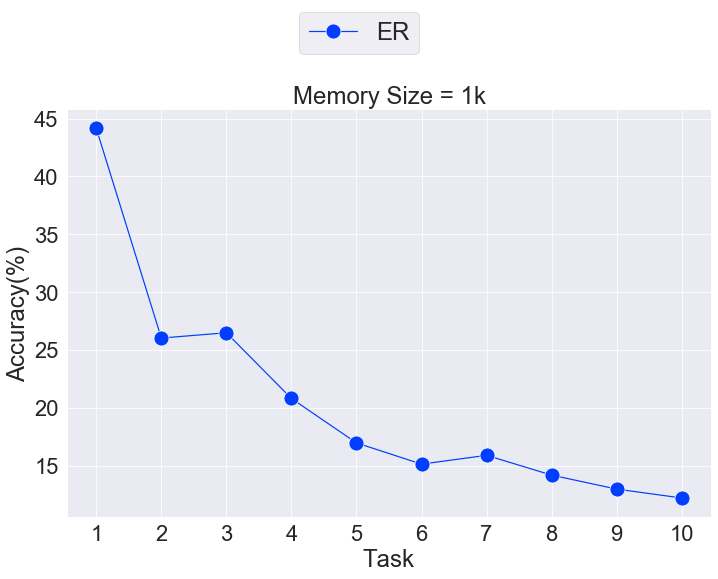

In [18]:
# agents = ['AGEM', 'CNDPM', 'EWC', 'finetune', 'GDUMB', 'GSS', 'MIR', 'ICARL', 'LWF', 'ER']
# agents_name = ['A-GEM', 'CN-DPM', 'EWC++', 'Finetune', 'GDumb', 'GSS', 'MIR', 'iCaRL', 'LwF', 'ER']
agents = ['ER']
agents_name = ['ER']
no_m_agent = ['EWC', 'LWF', 'finetune']
# mem = ['1k', '5k', '10k']
mem = ['1k']
sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=2.5)
acc_plot_all_mem(file_name='cifar_nc_allmem.pdf', save=False, dataset='cifar100', 
                     agents=agents, mem=mem, task=10, print_name=agents_name)
# acc_plot_all_mem(file_name='mini_nc_allmem.pdf', save=True, dataset='mini_imagenet', 
#                      agents=agents, mem=mem, task=18, print_name=agents_name)
# acc_plot_all_mem(file_name='core_nc_allmem.pdf', save=True, dataset='core50', 
#                      agents=agents, mem=mem, task=9, cl_type='nc', print_name=agents_name)


# agents_ni = ['AGEM', 'CNDPM', 'EWC', 'finetune', 'GDUMB', 'GSS', 'MIR', 'LWF', 'ER']
# agents_ni_name = ['A-GEM', 'CN-DPM', 'EWC++', 'Finetune', 'GDumb', 'GSS', 'MIR', 'LwF', 'ER']
# acc_plot_all_mem(file_name='noise_allmem.pdf', save=True, dataset='mini_imagenet-noise', 
#                      agents=agents_ni, mem=mem, task=10, cl_type='ni', print_name=agents_ni_name)
# acc_plot_all_mem(file_name='occlusion_allmem.pdf', save=True, dataset='mini_imagenet-occlusion', 
#                      agents=agents_ni, mem=mem, task=10, cl_type='ni', print_name=agents_ni_name)
# acc_plot_all_mem(file_name='coreni_allmem.pdf', save=True, dataset='core50', 
#                      agents=agents_ni, mem=mem, task=8, cl_type='ni', print_name=agents_ni_name)

## Acc Plot - one mem

In [78]:
def acc_plot_one(file_name='cifar_nc.pdf', legend=True, save=True, dataset='cifar100', 
                     agents=agents, mem=mem, task=18, y_label='Accuracy(%)', cl_type='nc'):
    tmp_dict = {}
    x_data = []
    acc_data = []
    trick_data = []
    mem_data = []
    agent_data = []
    file_path = 'result/{}/{}/'.format(dataset, cl_type)
    plt.figure(figsize=(12, 8))
    for agent in agents:
        for m in mem:
            if agent in no_m_agent:
                ram, time, best_param, acc = find_files(file_path, agent)
            else:

                ram, time, best_param, acc = find_files(file_path, agent+'_'+m)

            if acc is not None:
                avg_acc_mean_multiple_run = np.mean(avg_acc(acc), axis=0)*100
                n = avg_acc_mean_multiple_run.shape[0]
                x_data += [i for i in range(1, n+1)]
                acc_data += (avg_acc_mean_multiple_run.tolist())
                mem_data += [m]*n
                agent_data += [agent]*n
    tmp_dict['data'] = acc_data
    tmp_dict['Memory Size'] = mem_data
    tmp_dict['Method'] = agent_data
    tmp_dict['task'] = x_data
    data_preproc = pd.DataFrame(tmp_dict)
    marker = Line2D.filled_markers[:len(set(agent_data))]
    mpl.rcParams['lines.markersize'] = 9
    g = sns.lineplot(x='task', y='data',data=data_preproc, hue="Method",
                    style='Method', dashes=False, legend=False, markers=marker)
    g.set_ylabel(y_label)
#     g.yaxis.tick_right()
#     g.yaxis.set_label_position("right")
    g.set_xlabel('Task')
    g.set(xticks=[i for i in range(1, task+1)])
    g.set(xticks=[1,3,5,7,9,11,13,15,17,18])
    #g.set(yticks=[])
#     print([i for i in g.legend(fontsize='small').get_texts()])
    plt.legend(labels=agents_name,fontsize='small')
    plt.show(g)
    if save:
        g.figure.savefig(file_name, format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

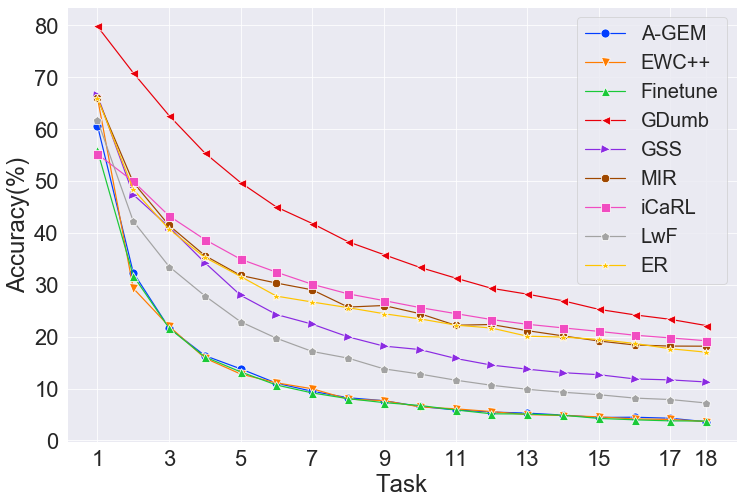

In [80]:
agents = ['AGEM', 'CNDPM', 'EWC', 'finetune', 'GDUMB', 'GSS', 'MIR', 'ICARL', 'LWF', 'ER']
agents_name = ['A-GEM', 'EWC++', 'Finetune', 'GDumb', 'GSS', 'MIR', 'iCaRL', 'LwF', 'ER']
no_m_agent = ['EWC', 'LWF', 'finetune']
mem = ['5k']
#sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=2.5)
acc_plot_one(file_name='cifar_nc.pdf', legend=True, save=True, dataset='cifar100', 
                     agents=agents, mem=mem, task=18)
# acc_plot_one(file_name='core_nc.pdf', legend=False, save=True, dataset='core50', 
#                      agents=agents, mem=mem, task=9,y_label='')
# acc_plot_one(file_name='mini_nc.pdf', legend=False, save=True, dataset='mini_imagenet', 
#                      agents=agents, mem=mem, task=18, y_label='')
# acc_plot_one(file_name='mini_occlusion.pdf', legend=False, save=True, dataset='mini_imagenet', 
#                      agents=agents, mem=mem, task=10, cl_type='ni/occlusion', y_label='')
# acc_plot_one(file_name='core_ni.pdf', legend=True, save=False, dataset='core50', 
#                      agents=agents, mem=mem, task=8, cl_type='ni/', y_label='')

## Rader Plot

In [23]:
def normal(data, a, b):
    max_, min_ = max(data), min(data)
    new = (b-a)*(data-min_)/(max_-min_)+a
    return new


In [24]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    #$theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    n = 1
    n_ = (1-n*2/3)/3+n*2/3
    theta = np.linspace(0, 2*np.pi*n, 3, endpoint=False)
    theta = np.concatenate((theta, np.linspace(2*np.pi*n_, 2*np.pi, 2, endpoint=False)))
    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)
                
        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


In [25]:
agents = ['AGEM', 'CNDPM', 'EWC', 'GDUMB', 'GSS', 'MIR', 'ICARL', 'LWF', 'ER']
#agents = ['AGEM', 'GDUMB', 'GSS', 'MIR', 'ICARL', 'ER']
# no_m_agent = ['EWC', 'LWF', 'finetune', 'CNDPM']
mem = ['5k']
# metric = ['End_ACC', 'FWT', 'BWT', 'FGT', 'Time']
metric = ['End_ACC', 'FGT', 'Time', 'FWT', 'BWT']
datasets = ['cifar100', 'mini_imagenet', 'core50']
#datasets = ['cifar100']
# radar_data = [metric, ('CIFAR-100', dataset_all_arr), ('Mini_ImageNet', ), ('CORe50-NC', )]

In [29]:
def collect_radar_data(datasets, agents, mem):
    total_data = []
    for dataset in datasets:    
        file_path = 'result/{}/{}/'.format(dataset, 'nc')
        with open('run_time_'+dataset+'.csv', "r") as f:
            time_single = {}
            data = f.read().splitlines()[1:]
            time_pred = []
            for i in data:
                tmp = i.split(',')
                if tmp[1]:
                    time_single[tmp[0]] = int(tmp[1])
        dataset_all = []
        for agent in agents:
            agent_data = []
            for m in mem:
                if agent in no_m_agent:
                    ram, time, best_param, acc = find_files(file_path, agent)
                else:

                    ram, time, best_param, acc = find_files(file_path, agent+'_'+m)

                if acc is not None:
                    avg_end_acc, avg_end_fgt, avg_acc, avg_bwtp, avg_fwt = compute_performance(acc)
                    agent_data.append(avg_end_acc[0])
                    #agent_data.append(avg_acc[0])
                    agent_data.append(-avg_end_fgt[0])
                    agent_data.append(-time_single[agent])
                    agent_data.append(avg_fwt[0])
                    agent_data.append(avg_bwtp[0])                 
                    #print(agent_data)
            dataset_all.append(agent_data)
        total_data.append(dataset_all)
    dataset_all_arr = np.array(total_data)
    print(dataset_all_arr.shape)
    min_max_scaler = preprocessing.MinMaxScaler()
    for k in range(len(datasets)):
        for i in range(3):

            dataset_all_arr[k, :, i] = normal(dataset_all_arr[k, :, i], 0.1, 1)

    
    return dataset_all_arr

In [30]:
dataset_all_arr = collect_radar_data(datasets, agents, mem)

(3, 9, 5)


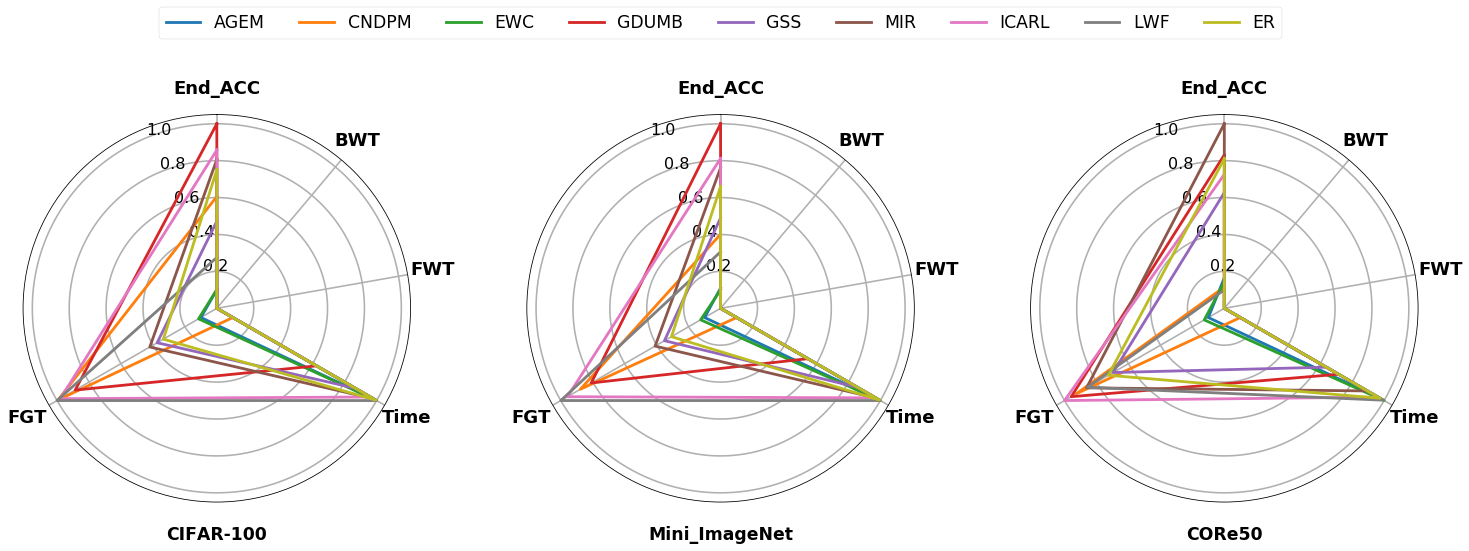

In [31]:
from matplotlib.cm import get_cmap
name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list
plt.style.use('seaborn-poster')
radar_data = [metric, ('CIFAR-100', dataset_all_arr[0]), ('Mini_ImageNet', dataset_all_arr[1]), ('CORe50', dataset_all_arr[2])]
theta = radar_factory(5, frame='circle')
spoke_labels = radar_data.pop(0)
fig, axs = plt.subplots(figsize=(25, 25), nrows=1, ncols=3,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.3, hspace=0.20)

for ax, (title, case_data) in zip(axs.flat, radar_data):
    ax.set_title(title, weight='bold', size='xx-large', position=(0.5, -0.1),
                  horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        #ax.fill(theta, d, alpha=0.90)
    ax.set_varlabels(spoke_labels)
labels = agents
legend = plt.legend(labels,fontsize='xx-large', loc='upper center', ncol=len(labels), bbox_to_anchor=(-0.8, 1.3))
 
fig.subplots_adjust(top=2)
for ax in axs.flat:
    ax.tick_params(axis='x', which='major', pad=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
        tick.label.set_fontweight('bold')
    
plt.show()

fig.savefig('radar_5k.pdf', format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

### Multi-bar plot

In [14]:
def multi_bar(file_name='nc_bar.pdf', save=True, data_name={}, datasets=[], 
                     agents=[], mem=[], cl_type='nc', print_name=[]):
    tmp_dict = {}
    data = []
    measure_data = []
    dataset_data = []
    agent_data = []
    for dataset in datasets:
        if cl_type == 'ni':
            dataset_, scenario = dataset.split('-')
            file_path = 'result/{}/ni/{}'.format(dataset_, scenario)
            run_time_file = 'run_time_'+dataset_+'_'+'ni'+'.csv'
        else:
            dataset_ = dataset
            file_path = 'result/{}/{}/'.format(dataset, 'nc')
            run_time_file = 'run_time_'+dataset_+'.csv'
        
        with open(run_time_file, "r") as f:
            time_single = {}
            lines = f.read().splitlines()[1:]
            time_pred = []
            for i in lines:
                tmp = i.split(',')
                if tmp[1]:
                        time_single[tmp[0]] = int(tmp[1])
        for agent in agents:
            for m in mem:
                if agent in no_m_agent:
                    ram, time, best_param, acc = find_files(file_path, agent)
                else:

                    ram, time, best_param, acc = find_files(file_path, agent+'_'+m)

                if acc is not None:
                    avg_end_acc, avg_end_fgt, avg_acc, avg_bwtp, avg_fwt = compute_performance(acc)
                    data.append(avg_end_acc[0]*100)
                    measure_data.append('Accuracy(%)')
                    agent_data.append(agent)
                    dataset_data.append(data_name[dataset])
                    data.append(avg_end_fgt[0]*100)
                    measure_data.append('Forgetting(%)')
                    agent_data.append(agent)
                    dataset_data.append(data_name[dataset])
                    data.append(time_single[agent])
                    measure_data.append('Time(s)')
                    agent_data.append(agent)
                    dataset_data.append(data_name[dataset])
                    if dataset_ == 'core50' and cl_type == 'ni':
                        avg_fwt = (0,0)
                        avg_bwtp = (0, 0)
                    data.append(avg_fwt[0]*100)
                    measure_data.append('Forward Transfer(%)')
                    #agent_data.append(agent_name[agent])
                    agent_data.append(agent)
                    dataset_data.append(data_name[dataset])
                    data.append(avg_bwtp[0]*100)
                    measure_data.append('Backward Transfer(%)')
                    agent_data.append(agent)
                    dataset_data.append(data_name[dataset])
        tmp_dict['Measurement'] = data
        tmp_dict['Metric'] = measure_data
        tmp_dict['Method'] = agent_data
        tmp_dict['Dataset'] = dataset_data
        data_preproc = pd.DataFrame(tmp_dict) 
    g = sns.catplot(x="Method", y="Measurement", row='Dataset', col='Metric', kind="bar", 
                    sharey=False, margin_titles=True, 
                    data=data_preproc, legend=True, legend_out=True)
    g.set_xticklabels(rotation=45,horizontalalignment='right')
    Ax = g.axes[0][0]
    Boxes = [item for item in Ax.get_children()
             if isinstance(item, mpl.patches.Rectangle)][:-1]
    # There is no labels, need to define the labels
    legend_labels  = print_name
    # Create the legend patches
    legend_patches = [mpl.patches.Patch(color=C, label=L) for
                      C, L in zip([item.get_facecolor() for item in Boxes],
                                  legend_labels)]
    if cl_type == 'nc':
        g.fig.subplots_adjust(bottom=0.15)
    else:
        g.fig.subplots_adjust(bottom=0.11)
    g.fig.legend(handles=legend_patches,loc='lower center', ncol=len(agents), fontsize='medium')
    if save:
        g.fig.savefig(file_name, format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

['GDumb', 'iCaRL', 'MIR', 'ER', 'CN-DPM', 'GSS', 'LwF', 'A-GEM', 'EWC++', 'Finetune']
['GDUMB', 'ICARL', 'MIR', 'ER', 'CNDPM', 'GSS', 'LWF', 'AGEM', 'EWC', 'finetune']


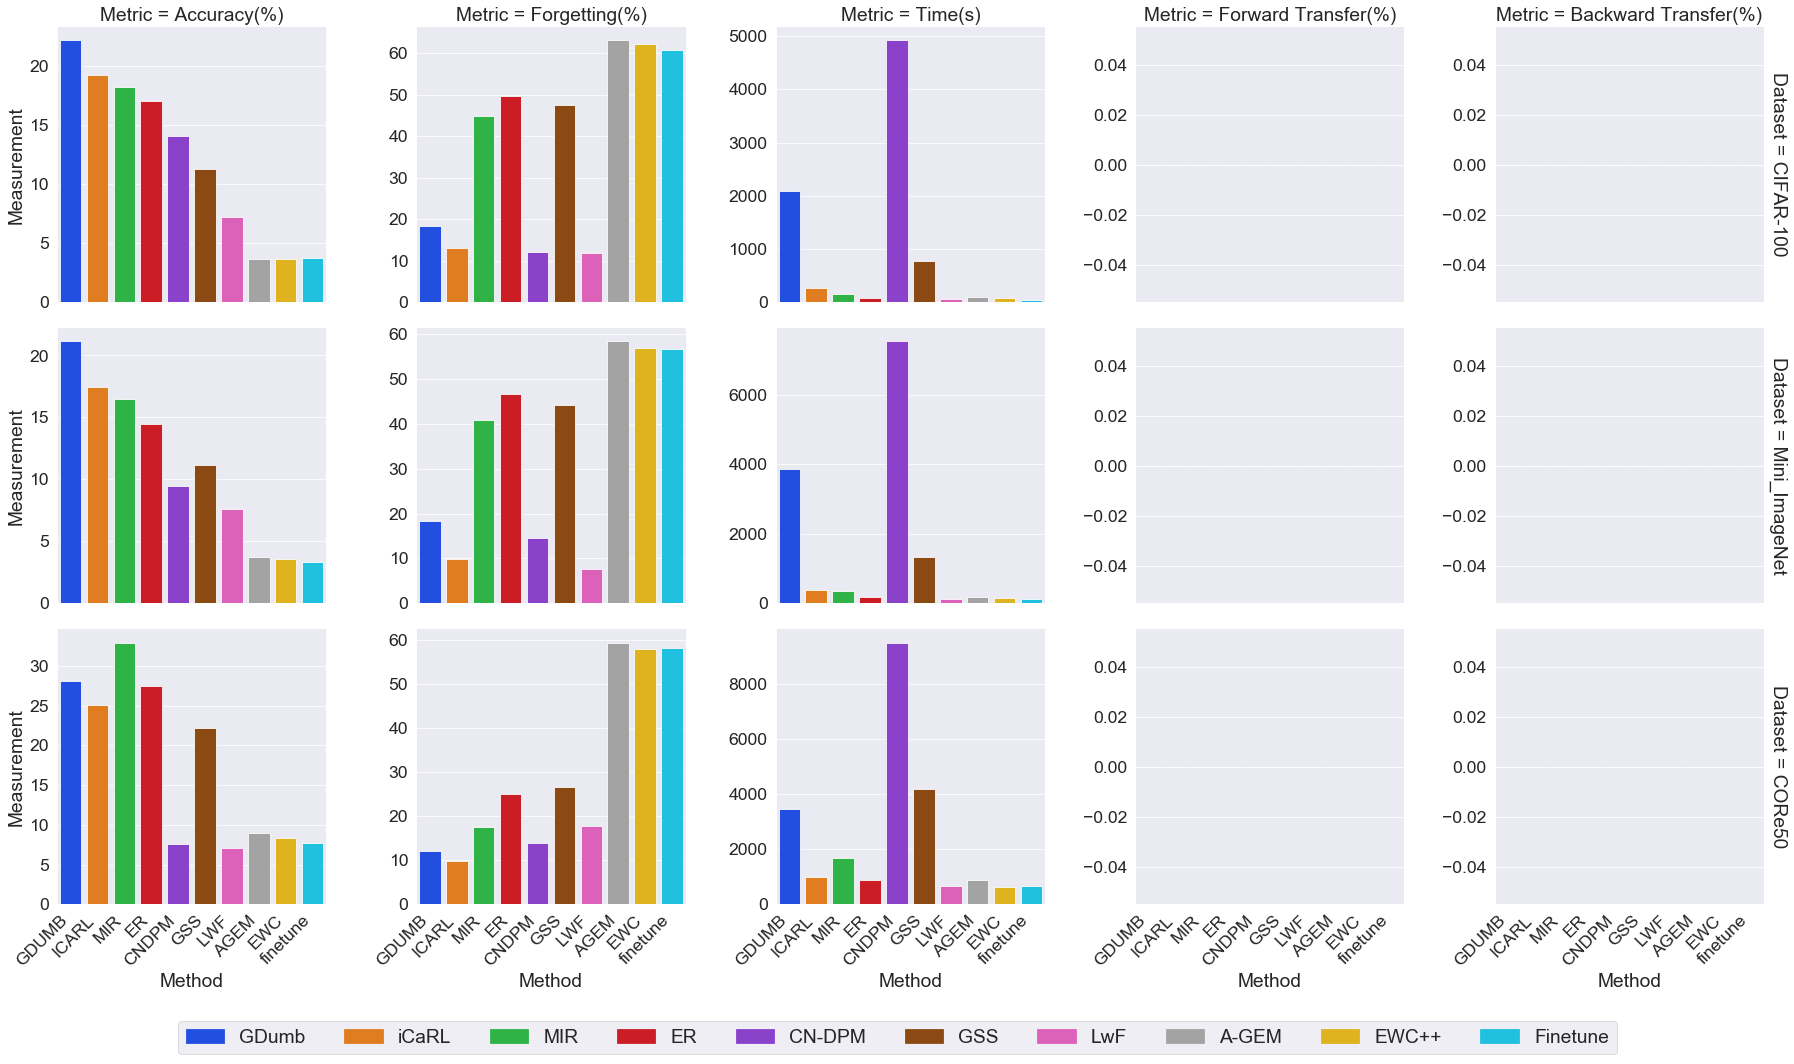

In [17]:
sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=2)
agents = ['GDUMB', 'ICARL', 'MIR', 'ER', 'CNDPM', 'GSS', 'LWF', 'AGEM', 'EWC', 'finetune']
agents_ni = ['GDUMB','MIR', 'ER', 'CNDPM', 'GSS', 'LWF', 'AGEM', 'EWC', 'finetune']
agents_ni_name = ['GDumb','MIR', 'ER', 'CN-DPM', 'GSS', 'LwF', 'A-GEM', 'EWC++', 'Finetune']
agents_name = ['GDumb', 'iCaRL', 'MIR', 'ER', 'CN-DPM', 'GSS', 'LwF', 'A-GEM', 'EWC++', 'Finetune']
# agents_ni = ['ER',]
no_m_agent = ['EWC', 'LWF', 'finetune', 'CNDPM']
mem = ['5k']
datasets = ['cifar100', 'mini_imagenet', 'core50']
datasets_ni = ['mini_imagenet-noise', 'mini_imagenet-occlusion' ,'mini_imagenet-blur',  'core50-']
# datasets_ni = ['core50-']
data_name = {'cifar100': 'CIFAR-100', 'mini_imagenet':'Mini_ImageNet', 'core50': 'CORe50'}
data_name_ni = {'mini_imagenet-blur': 'Mini_ImageNet-Blur', 'mini_imagenet-noise':'Mini_ImageNet-Noise', 
             'mini_imagenet-occlusion': 'Mini_ImageNet-Occlusion','core50-': 'CORe50'}
multi_bar(file_name='nc_bar.pdf', save=True, data_name=data_name, datasets=datasets, 
                     agents=agents, mem=mem, cl_type='nc', print_name=agents_name)
# multi_bar(file_name='ni_bar.pdf', save=True, data_name=data_name_ni, datasets=datasets_ni, 
#                      agents=agents_ni, mem=mem, cl_type='ni', print_name=agents_ni_name)

## Error Analysis

In [235]:
cifar_error_er_5k = [(0, 185, 0, 0), (31, 186, 27, 328), (42, 116, 172, 595), (60, 124, 256, 893), (36, 101, 336, 1224), (26, 112, 347, 1658), (57, 116, 673, 1640), (58, 195, 897, 1848), (43, 106, 871, 2315), (80, 140, 1092, 2553), (71, 67, 1428, 2535), (40, 105, 1087, 3451), (56, 98, 1335, 3603), (91, 137, 1405, 3875), (47, 98, 1374, 4675), (22, 84, 1089, 5492), (60, 128, 1946, 4799), (57, 88, 1864, 5328), (43, 59, 1811, 5967), (37, 148, 2269, 5852)]
#cifar_error_MIR_5k = [(0, 187, 0, 0), (98, 149, 73, 263), (132, 101, 165, 569), (120, 76, 371, 769), (64, 99, 367, 1268), (56, 64, 597, 1298), (128, 87, 969, 1192), (91, 154, 902, 1721), (78, 96, 1126, 2050), (85, 104, 1349, 2249), (78, 54, 1491, 2434), (37, 143, 1159, 3325), (47, 146, 1172, 3798), (75, 107, 1593, 3719), (47, 132, 1747, 4054), (41, 62, 1713, 4558), (72, 144, 1945, 4693), (42, 87, 1835, 5299), (63, 46, 2168, 5489), (106, 118, 3377, 4715)]
cifar_error_MIR_5k = [(0, 219, 0, 0), (165, 60, 147, 162), (81, 83, 203, 419), (113, 171, 172, 868), (62, 152, 296, 1158), (95, 114, 587, 1181), (117, 106, 566, 1723), (95, 53, 1052, 1811), (90, 179, 1022, 2168), (78, 150, 1071, 2425), (100, 100, 1397, 2590), (75, 117, 1228, 3245), (67, 86, 1001, 4175), (35, 118, 1754, 3747), (80, 121, 2111, 3747), (84, 46, 2418, 3856), (70, 68, 2202, 4401), (63, 64, 2310, 4886), (59, 87, 2252, 5408), (54, 113, 2770, 5330)]
cifar_error_gdumb_5k = [(0, 126, 0, 0), (92, 82, 81, 111), (111, 71, 318, 200), (202, 40, 570, 208), (219, 42, 884, 254), (229, 27, 1279, 239), (240, 40, 1610, 218), (303, 79, 1960, 325), (308, 25, 2311, 394), (359, 27, 2866, 196), (303, 10, 3271, 270), (315, 35, 3610, 449), (412, 16, 4212, 359), (397, 31, 4651, 376), (412, 15, 5121, 357), (356, 16, 5676, 353), (415, 34, 6107, 501), (429, 5, 6685, 345), (421, 5, 7226, 280), (377, 43, 7673, 537)]
cifar_error_agem_5k = [(0, 190, 0, 0), (0, 218, 0, 500), (0, 125, 0, 1000), (0, 140, 0, 1500), (0, 137, 0, 2000), (0, 99, 0, 2500), (0, 144, 0, 3000), (0, 245, 0, 3500), (0, 132, 0, 4000), (0, 163, 0, 4500), (0, 99, 0, 5000), (0, 150, 0, 5500), (0, 157, 0, 6000), (0, 176, 0, 6500), (0, 162, 0, 7000), (0, 95, 0, 7500), (0, 211, 0, 8000), (0, 137, 0, 8500), (0, 103, 0, 9000), (0, 177, 0, 9500)]
cifar_error_ft = [(0, 190, 0, 0), (0, 226, 0, 500), (0, 130, 0, 1000), (0, 160, 0, 1500), (0, 134, 0, 2000), (0, 115, 0, 2500), (0, 123, 0, 3000), (0, 240, 0, 3500), (0, 167, 0, 4000), (0, 167, 0, 4500), (0, 166, 0, 5000), (0, 153, 0, 5500), (0, 173, 0, 6000), (0, 167, 0, 6500), (0, 178, 0, 7000), (0, 122, 0, 7500), (0, 211, 0, 8000), (0, 124, 0, 8500), (0, 120, 0, 9000), (0, 169, 0, 9500)]

In [236]:
def error_ratio(errors):
    errors = errors[1:]
    no_r = [i[0]/(i[0]+i[1])*100 for i in errors]
    on_r = [i[3]/(i[2]+i[3])*100 for i in errors]
    return no_r, on_r


In [237]:
error_data = [('ER',cifar_error_er_5k),('MIR', cifar_error_MIR_5k), ('AGEM', cifar_error_agem_5k)]
#error_data = [('ER',cifar_error_er_5k),('MIR', cifar_error_MIR_5k), ('Finetune', cifar_error_ft), ('GDumb', cifar_error_gdumb_5k)]

In [53]:
tmp_dict = {}
x_data = []
agent_data = []
task_n = 9
e_data = []
e_type_data = []

for i in error_data:
    agent, error = i
    no_r, on_r = error_ratio(error)
    x_data += [i for i in range(1, task_n+1)]
    e_data += no_r 
    agent_data += [agent] * task_n
    e_type_data += ['er(n, o)'] * task_n
    
    x_data += [i for i in range(1, task_n+1)]
    e_data += on_r 
    e_type_data += ['er(o, n)'] * task_n
    agent_data += [agent] * task_n
    
tmp_dict['Error Ratio (%)'] = e_data
tmp_dict['Task'] = x_data
tmp_dict['Method'] = agent_data
tmp_dict['Error Type'] = e_type_data
data_preproc = pd.DataFrame(tmp_dict)

NameError: name 'error_data' is not defined

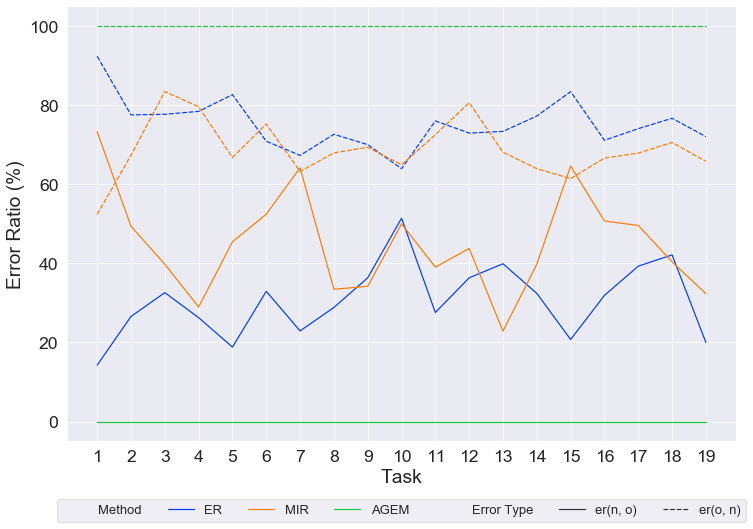

In [239]:
plt.figure(figsize=(12, 8))
sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=2)
g = sns.lineplot(data=data_preproc, x="Task", y="Error Ratio (%)", hue="Method", style="Error Type")
g.set(xticks=[i for i in range(1, task_n+1)])
# g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
g.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=7,  prop={'size': 13})
g.get_figure().savefig('error_cifar.pdf', format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

In [227]:
MIR_5k_ciar_nscore = [7.453387619018555, 6.0307339019775394, 5.164552688598633, 5.485821456909179, 4.582923633575439, 4.640730651855469, 4.3393360786437984, 3.9910450611114503, 3.9614843521118166, 4.376326946258545, 4.180630531311035, 3.8372236633300782, 3.6043907833099365, 3.383526475906372, 3.7821471767425536, 3.389999906539917, 3.6753768901824952, 3.1641622734069825, 3.591384059906006, 3.6543085231781007]
MIR_5k_ciar_oscore = [0, 5.59938920211792, 4.062617336273194, 3.2481845531463622, 2.908405045509338, 2.583080391693115, 2.194196057955424, 2.0179463178089687, 1.6536660476922989, 1.4284165504243638, 1.290113943386078, 1.0350869678150523, 0.9318614557981492, 0.7310814796227675, 0.5273922463825771, 0.38665762330691017, 0.20841195496171713, 0.08069305170809521, -0.08190346890025668, -0.21736271659951462]
ER_5k_ciar_nscore = [7.037532718658447, 5.603315547943115, 5.614890983581543, 5.5591787872314455, 4.5496782836914065, 4.6059601058959965, 4.475293334960938, 4.091988079071045, 4.348091968536377, 4.389869075775146, 4.194539619445801, 3.8978858985900877, 3.449463764190674, 3.5663773727416994, 3.9266076126098635, 3.5122782859802246, 3.7782954120635988, 3.2808838214874267, 3.689221239089966, 3.649157911300659]
ER_5k_ciar_oscore = [0, 4.979461486816406, 3.9206223278045655, 3.163873165130615, 2.7980399508476257, 2.477305966567993, 2.1603266299565633, 1.9635601739883424, 1.695923747420311, 1.4293510114881727, 1.2523290415763855, 1.0589785764000632, 0.8854806108474731, 0.7635376686683067, 0.5463988453660692, 0.38191947259902953, 0.2019955905005336, 0.046326103245072504, -0.10621022889018059, -0.2138320108401148]
AGEM_5k_ciar_nscore = [6.643845558166504, 6.385321731567383, 6.08712264251709, 6.751744041442871, 6.058417083740235, 6.580390739440918, 6.133210155487061, 6.1277691230773925, 5.842343166351318, 6.390997100830078, 6.125016204833984, 6.139840976715088, 5.646382881164551, 5.7889176330566405, 5.960501033782959, 5.740186599731445, 6.048905586242676, 5.575814208984375, 6.008505199432373, 5.854794303894043]
AGEM_5k_ciar_oscore = [0, 2.257275323867798, 1.781468855857849, 1.422093839009603, 1.2750348312854767, 1.038038657951355, 0.9545041408538818, 0.8563364837510246, 0.6327191995978355, 0.5282112754715813, 0.4560301256418228, 0.3566756723360582, 0.26789597366253537, 0.17589968233842115, 0.05286005856522492, 0.002078741549467668, -0.12731900458037854, -0.1679668086416581, -0.24786235837803947, -0.30531475569072525]


In [228]:
logit = [('MIR', (MIR_5k_ciar_nscore, MIR_5k_ciar_oscore)), ('ER', (ER_5k_ciar_nscore, ER_5k_ciar_oscore)), ('AGEM', (AGEM_5k_ciar_nscore, AGEM_5k_ciar_oscore))]

In [54]:
def plot_compre(data, y_name, save=None):
    tmp_dict = {}
    x_data = []
    agent_data = []
    task_n = 9
    e_data = []
    type_data = []

    for i in data:
        agent, (n, o) = i
        n, o = n[1:], o[1:]

        x_data += [i for i in range(1, task_n+1)]
        e_data += n 
        agent_data += [agent] * task_n
        type_data += ['New Class'] * task_n

        x_data += [i for i in range(1, task_n+1)]
        e_data += o 
        agent_data += [agent] * task_n
        type_data += ['Old Class'] * task_n

    tmp_dict[y_name] = e_data
    tmp_dict['Task'] = x_data
    tmp_dict['Method'] = agent_data
    tmp_dict['Type'] = type_data
    data_preproc = pd.DataFrame(tmp_dict)
    plt.figure(figsize=(12, 8))
    sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=2)
    g = sns.lineplot(data=data_preproc, x="Task", y=y_name, hue="Method", style="Type")
    g.set(xticks=[i for i in range(1, task_n+1)])
    g.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=7,  prop={'size': 13})
    if save:
        g.get_figure().savefig(save, format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

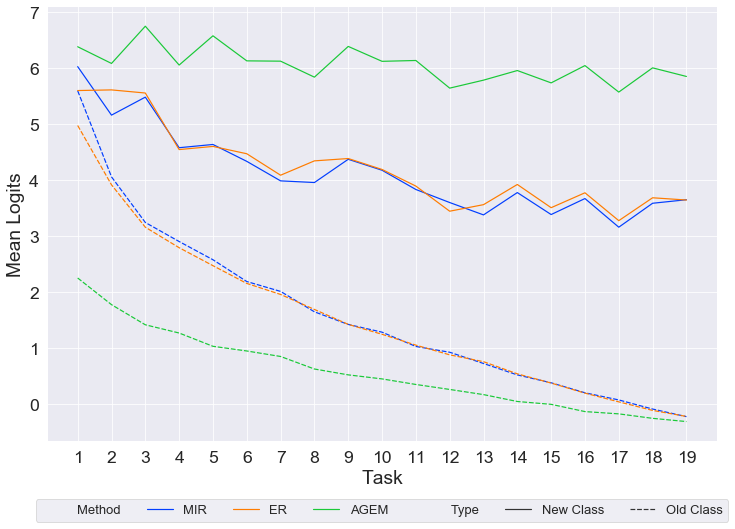

In [230]:
plot_compre(logit, 'Mean Logits')

In [231]:
er_bias_o = ['nan', 0.049737222492694855, 0.024388130754232407, 0.024449288845062256, 0.030511965975165367, 0.022357985377311707, 0.022067906334996223, 0.01565493270754814, 0.011576255783438683, 0.011498688720166683, 0.007742650341242552, 0.008002744987607002, 0.00656732264906168, 0.004946592263877392, 0.0010166286956518888, 0.0005512030911631882, -0.0015264414250850677, -0.0023154558148235083, -0.003483418608084321, -0.0036122449673712254]
er_bias_n = [0.06577698141336441, 0.021659230813384056, 0.05116084963083267, 0.07617603987455368, 0.019541995599865913, 0.04983506724238396, 0.006523513700813055, 0.016897408291697502, 0.04684529826045036, 0.008552798070013523, 0.046363141387701035, 0.025770438835024834, 0.020115284249186516, -0.010966524481773376, 0.03035937063395977, 0.007719178684055805, 0.021733148023486137, 0.0161819476634264, 0.03316570818424225, 0.01500984001904726]
AGEM_bias_o = ['nan', 0.027044177055358887, 0.008793282322585583, 0.010512287728488445, 0.018779335543513298, 0.011073056608438492, 0.012700430117547512, 0.007551934104412794, 0.00452932296320796, 0.0050670490600168705, 0.0020721552427858114, 0.0031378413550555706, 0.002240014960989356, 0.0010707385372370481, -0.002263214671984315, -0.002312063705176115, -0.004075444769114256, -0.004515914712101221, -0.00536163616925478, -0.0052495175041258335]
AGEM_bias_n = [0.0616842620074749, 0.02866443432867527, 0.058396220207214355, 0.08863291144371033, 0.03319225087761879, 0.07070241123437881, 0.02547013759613037, 0.036030612885951996, 0.06713616102933884, 0.031824640929698944, 0.07016550749540329, 0.04861006140708923, 0.04449554905295372, 0.014710028655827045, 0.055040400475263596, 0.033464379608631134, 0.04942912980914116, 0.04475880786776543, 0.0627637654542923, 0.04611748456954956]
mir_bias_o = ['nan', 0.050887297838926315, 0.025715798139572144, 0.025190070271492004, 0.03082771971821785, 0.02253607288002968, 0.02203679084777832, 0.015827391296625137, 0.01188232284039259, 0.011611571535468102, 0.007771467324346304, 0.008015158586204052, 0.006629971321672201, 0.005051963031291962, 0.0010811863467097282, 0.000567491864785552, -0.0014705451903864741, -0.0023601166903972626, -0.0035117606166750193, -0.00367362261749804]
mir_bias_n = [0.06645642966032028, 0.02115362323820591, 0.04974091798067093, 0.07415661215782166, 0.0186705831438303, 0.04920293018221855, 0.006948343012481928, 0.01634574867784977, 0.04531710222363472, 0.008720037527382374, 0.047389790415763855, 0.02673739194869995, 0.020031943917274475, -0.011866993270814419, 0.029871497303247452, 0.007736891508102417, 0.0210774727165699, 0.01698884554207325, 0.03362568840384483, 0.016175953671336174]




In [232]:
bias = [('MIR', (mir_bias_n, mir_bias_o)), ('ER', (er_bias_n, er_bias_o)), ('AGEM', (AGEM_bias_n, AGEM_bias_o))]

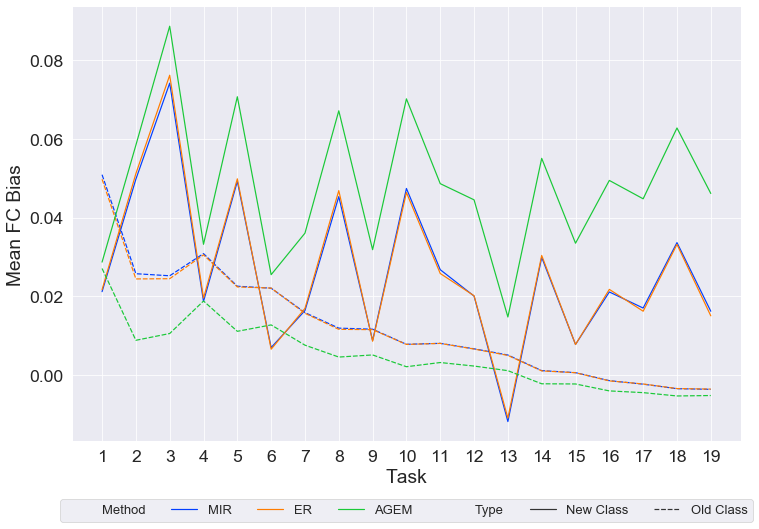

In [233]:
plot_compre(bias, 'Mean FC Bias', save='cifar_5k_bias.pdf')

In [221]:
er_w_o = ['nan', 0.034168507903814316, 0.02584986202418804, 0.021495189517736435, 0.019102947786450386, 0.016461672261357307, 0.014384637586772442, 0.012954063713550568, 0.010927502997219563, 0.00923746358603239, 0.0080259395763278, 0.006804760545492172, 0.005729397293180227, 0.0045847236178815365, 0.0032349389512091875, 0.002404587110504508, 0.0012442467268556356, 0.0004872183781117201, -0.0004953290335834026, -0.001287844032049179]
er_w_n = [0.04795055463910103, 0.03721845522522926, 0.03591497987508774, 0.03606914356350899, 0.032057132571935654, 0.03108113445341587, 0.030093111097812653, 0.026792775839567184, 0.028380516916513443, 0.029624303802847862, 0.02689744345843792, 0.025509217754006386, 0.022774338722229004, 0.021912045776844025, 0.02490035630762577, 0.021943964064121246, 0.024241186678409576, 0.02127004601061344, 0.02320392057299614, 0.022067559882998466]
AGEM_w_o = ['nan', 0.015841010957956314, 0.01281492318958044, 0.010024801827967167, 0.00926465354859829, 0.007288771215826273, 0.00668941019102931, 0.00600664084777236, 0.005127732641994953, 0.003923783078789711, 0.003362509422004223, 0.002664186293259263, 0.0021121485624462366, 0.0013525435933843255, 0.000543161469977349, 8.24653689051047e-05, -0.0006915656849741936, -0.0010667601600289345, -0.0017482016701251268, -0.002240577479824424]
AGEM_w_n = [0.04461028799414635, 0.042200811207294464, 0.0414138026535511, 0.04468994960188866, 0.04178682342171669, 0.04452129080891609, 0.04193398728966713, 0.04051532968878746, 0.040499553084373474, 0.04404725134372711, 0.041428517550230026, 0.0408887080848217, 0.038748275488615036, 0.03908587992191315, 0.0409860759973526, 0.03910957649350166, 0.04151979461312294, 0.03832525014877319, 0.04127984121441841, 0.0401693619787693]
mir_w_o = ['nan', 0.03598344326019287, 0.027477910742163658, 0.022022459656000137, 0.019468102604150772, 0.016795752570033073, 0.014602205716073513, 0.013184651732444763, 0.011307214386761189, 0.009445088915526867, 0.008254379965364933, 0.006871378514915705, 0.005844827275723219, 0.004701719153672457, 0.0033715125173330307, 0.0024647563695907593, 0.0013214056380093098, 0.0005053043714724481, -0.0004619255487341434, -0.0013176052598282695]
mir_w_n = [0.048946574330329895, 0.036511991173028946, 0.0342014841735363, 0.0352705717086792, 0.03152638301253319, 0.03032613731920719, 0.029753057286143303, 0.026497477665543556, 0.026889028027653694, 0.029526783153414726, 0.02644038200378418, 0.026384569704532623, 0.02255484089255333, 0.021335287019610405, 0.02383403666317463, 0.02163415402173996, 0.023495107889175415, 0.021206386387348175, 0.022655796259641647, 0.022633017972111702]

In [223]:
weights = [('MIR', (mir_w_n, mir_w_o)), ('ER', (er_w_n, er_w_o)), ('AGEM', (AGEM_w_n, AGEM_w_o))]

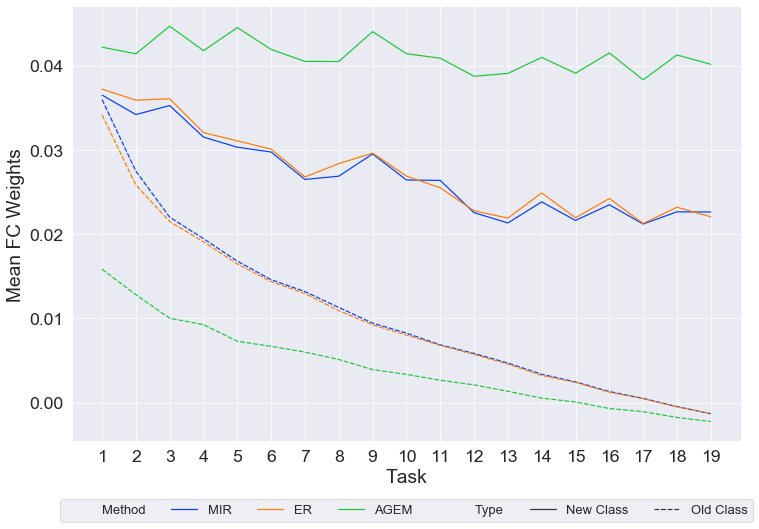

In [234]:
plot_compre(weights, 'Mean FC Weights', 'cifar_5k_w.pdf')

## Time for AAAI

In [48]:
rc('text', usetex=True)
time_aaai = {'LwF': 59, 'EWC++':72,'ER':74, 'A-GEM':90, 'MIR':160, r'ASER$_\mu$':320, 'GSS':727, r"\textbf{SCR}":278 }
time_aaai = pd.DataFrame(time_aaai.items(), columns=['Method', 'Run Time(s)'])

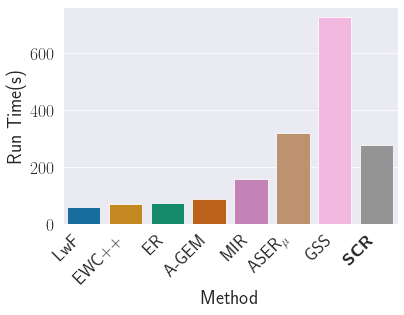

In [49]:
sns.set_theme(context='paper', style='darkgrid', palette='colorblind', font_scale=2)
g = sns.barplot(x="Method", y="Run Time(s)", data=time_aaai)
g.set_xticklabels(g.get_xticklabels(),rotation=45,horizontalalignment='right')
g.get_figure().savefig('train_time.pdf', format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

### CVPR


In [68]:
correct_lb, predict_lb = pickle.load(open('confusion_scr', 'rb'))

In [69]:
cf_matrix = confusion_matrix(correct_lb, predict_lb)

In [70]:
cf_matrix

array([[344,  31,  40,  56,  80,  60,  53,  84, 143, 109],
       [ 53, 312,  37, 106,  53,  46,  56,  52, 153, 132],
       [ 69,  31, 355,  57,  63,  33,  45,  90, 138, 119],
       [ 80,  54,  25, 304,  54,  35,  61,  76, 140, 171],
       [ 38,  36,  42,  52, 386,  66,  48,  82, 112, 138],
       [ 41,  35,  32,  43,  70, 412,  55,  44, 120, 148],
       [ 55,  31,  32,  44,  53,  51, 423, 102,  87, 122],
       [ 45,  31,  48,  41,  55,  45, 115, 416,  84, 120],
       [ 43,  62,  41,  51,  65,  54,  45,  31, 477, 131],
       [ 34,  28,  35,  88,  53,  58,  70,  90, 116, 428]])

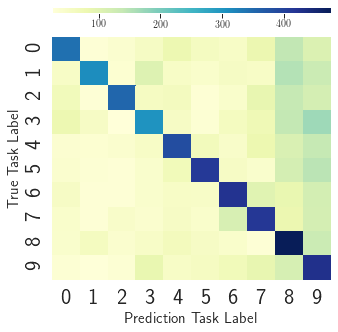

In [72]:
sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=2.5)
# Define two rows for subplots
fig, (cax, ax) = plt.subplots(nrows=2, figsize=(5,5.025),  gridspec_kw={"height_ratios":[0.025, 1]})

# Draw heatmap
sns.heatmap(cf_matrix, ax=ax, cbar=False, cmap='YlGnBu')

# colorbar
cbar = fig.colorbar(ax.get_children()[0], cax=cax, orientation="horizontal")
cbar.ax.tick_params(labelsize=10)
plt.ylabel('True Task Label', fontsize = 15) # x-axis label with fontsize 15
plt.xlabel('Prediction Task Label', fontsize = 15) # y-axis label with fontsize 15

plt.savefig('confusion_scr.pdf', format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')


In [70]:
ax.get_children()

 Text(0.5, 1, ''),
 Text(0.0, 1, ''),
 Text(1.0, 1, ''),

In [34]:
#2k
er_w_o = ['nan', 0.060363635420799255, 0.04534856230020523, 0.028719546273350716, 0.019781894981861115, 0.012417891062796116, 0.005886631086468697, 0.000558500352781266, -0.0034963670186698437, -0.006224535871297121]
er_w_n = [0.09396935999393463, 0.07693231850862503, 0.06186683848500252, 0.06449789553880692, 0.05743255838751793, 0.05281546339392662, 0.052907492965459824, 0.055433981120586395, 0.0568116158246994, 0.052989061921834946]
mir_w_o = ['nan', 0.05383634567260742, 0.040946826338768005, 0.026480643078684807, 0.017681164667010307, 0.010528192855417728, 0.004313826560974121, -0.0007999703520908952, -0.004132274072617292, -0.006651241797953844]
mir_w_n = [0.08031453937292099, 0.06867069005966187, 0.05766879767179489, 0.05957222357392311, 0.05548927187919617, 0.052440181374549866, 0.054021209478378296, 0.058818548917770386, 0.058567747473716736, 0.05682944133877754]
gss_w_o = ['nan', 0.06869368255138397, 0.04665394127368927, 0.030523797497153282, 0.020944755524396896, 0.013541365042328835, 0.006907782517373562, 0.0014608955243602395, -0.0028007631190121174, -0.006112565286457539]
gss_w_n = [0.09438177198171616, 0.06976350396871567, 0.061500415205955505, 0.06181274726986885, 0.05816557630896568, 0.051716554909944534, 0.050708621740341187, 0.05189512297511101, 0.05272217467427254, 0.05198131501674652]
aser_w_o = ['nan', 0.02051297202706337, 0.014860136434435844, 0.007849529385566711, 0.004176443908363581, 0.0020176165271550417, -0.00037151819560676813, -0.002289484953507781, -0.004005471244454384, -0.005057963542640209]
aser_w_n = [0.056459084153175354, 0.051156580448150635, 0.04414140433073044, 0.04627607390284538, 0.045724768191576004, 0.04224442318081856, 0.04222739487886429, 0.0427289716899395, 0.04432106763124466, 0.04248997941613197]

In [35]:
weights = [('MIR', (mir_w_n, mir_w_o)), ('ER', (er_w_n, er_w_o)), (r'ASER$_\mu$', (aser_w_n, aser_w_o)), ('GSS', (gss_w_n, gss_w_o))]

In [61]:
def plot_compre(data, y_name, save=None):
    tmp_dict = {}
    x_data = []
    agent_data = []
    task_n = 9
    e_data = []
    type_data = []

    for i in data:
        agent, (n, o) = i
        n, o = n[1:], o[1:]

        x_data += [i for i in range(1, task_n+1)]
        e_data += n 
        agent_data += [agent] * task_n
        type_data += ['New Class'] * task_n

        x_data += [i for i in range(1, task_n+1)]
        e_data += o 
        agent_data += [agent] * task_n
        type_data += ['Old Class'] * task_n

    tmp_dict[y_name] = e_data
    tmp_dict['Task'] = x_data
    tmp_dict['Method'] = agent_data
    tmp_dict['Type'] = type_data
    data_preproc = pd.DataFrame(tmp_dict)
    plt.figure(figsize=(12, 8))
    g = sns.lineplot(data=data_preproc, x="Task", y=y_name, hue="Method", style="Type")
    g.set(xticks=[i for i in range(1, task_n+1)])
    g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=8,  prop={'size': 13})
    if save:
        g.get_figure().savefig(save, format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

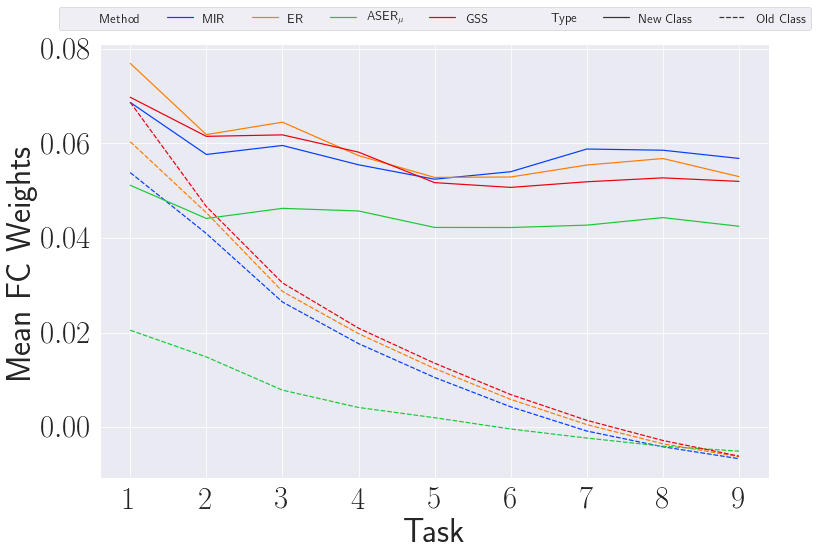

In [63]:
sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=3.5)
plot_compre(weights, 'Mean FC Weights', 'cifar_5k_w.pdf')

In [53]:
def find_files_cvpr(res_dir, name):
    acc = []
    for f in os.listdir(res_dir):
        f_path = os.path.join(res_dir, f)
        if f == name:
            output = pickle.load(open(f_path, 'rb'))
            acc.append(output['acc_array'])
    if acc:
        return np.vstack(acc)
    else:
        return None, None, None,None

In [29]:
datasets = ['cifar10', 'cifar100', 'mini_imagenet']
datasets_name = {'cifar10': 'CIFAR10', 'cifar100':'CIAFR100', 'mini_imagenet':'Mini ImageNet'}
agents = ['A-GEM', 'ER', 'GSS', 'MIR', 'ASER']
mem = ['05k', '2k', '2k']
tmp_dict = {}
acc_data = []
dataset_data = []
classifier_data = []
agent_data = []
for idx, dataset in enumerate(datasets):
    m = mem[idx]
    for agent in agents:
        file_path = 'result/{}/'.format(dataset)
        if agent == 'ER':
            acc = find_files_cvpr(file_path, 'Naive_ER'+'_'+m+'_'+dataset+'_nc.pkl')
            acc_ncm = find_files_cvpr(file_path, 'Naive_ER'+'_'+m+'_'+'ncm_'+dataset+'_nc.pkl')
        else:
            acc = find_files_cvpr(file_path, agent+'_'+m+'_'+dataset+'_nc.pkl')
            acc_ncm = find_files_cvpr(file_path, agent+'_'+m+'_'+'ncm_'+dataset+'_nc.pkl')
        end_acc = acc[:, -1, :]
        avg_end_acc = np.mean(end_acc, axis=1) *100
        
        end_acc_ncm = acc_ncm[:, -1, :]
        avg_end_acc_ncm = np.mean(end_acc_ncm, axis=1) *100
        

        n = avg_end_acc.shape[0]
        acc_data += (avg_end_acc.tolist())
        classifier_data += ['Softmax']*n
        dataset_data += [datasets_name[dataset]]*n
        if agent == 'ASER':
            agent = r'ASER$_\mu$'
        agent_data += [agent]*n
        
        acc_data += (avg_end_acc_ncm.tolist())
        classifier_data += ['NCM']*n
        dataset_data += [datasets_name[dataset]]*n
        agent_data += [agent]*n

tmp_dict['data'] = acc_data
tmp_dict['Classifier'] = classifier_data
tmp_dict['Dataset'] = dataset_data
tmp_dict['Method'] = agent_data
data_preproc = pd.DataFrame(tmp_dict) 

In [30]:
sns.set_theme(context='paper', style='darkgrid', palette='pastel', font='sans-serif', font_scale=2)

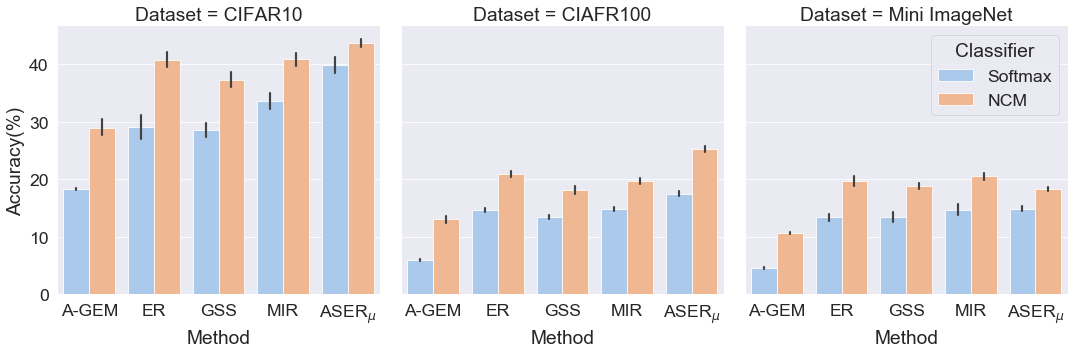

In [31]:
g = sns.catplot(x="Method", y="data", col='Dataset',hue="Classifier", kind="bar", data=data_preproc, legend=False, legend_out=False)
g.set_ylabels('Accuracy(%)')
plt.legend(title='Classifier', loc='upper right')
plt.show(g)
g.fig.savefig('ncm-sm.pdf', format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

In [45]:
sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=2.5)

In [144]:
def cvpr_line(dataset, m, num_task):
    agents = ['SCR', 'A-GEM', 'EWC', 'finetune', 'GSS', 'MIR', 'LWF', 'ER', 'ASER']
    agents_name = [r"\textbf{SCR(Ours)}", 'A-GEM', 'EWC++', 'Finetune','GSS', 'MIR', 'LwF', 'ER', r'ASER$_\mu$']
    no_m_agent = ['EWC', 'LWF', 'finetune']

    tmp_dict = {}
    x_data = []
    acc_data = []
    trick_data = []
    mem_data = []
    agent_data = []
    file_path = 'result/{}/'.format(dataset)


    for idx, agent in enumerate(agents):
        if agent in no_m_agent:
            acc = find_files_cvpr(file_path, agent+'_'+dataset+'_nc.pkl')
        else:
            if agent == 'ER':
                acc = find_files_cvpr(file_path, 'Naive_ER'+'_'+m+'_'+'ncm_'+dataset+'_nc.pkl')
            elif agent in ['SCR']:
                acc = find_files_cvpr(file_path, agent+'_'+m+'_'+dataset+'_nc.pkl')
            else:
                acc = find_files_cvpr(file_path, agent+'_'+m+'_'+'ncm_'+dataset+'_nc.pkl')
        avg_acc_mean_multiple_run = np.mean(avg_acc(acc), axis=0)*100
        n = avg_acc_mean_multiple_run.shape[0]
        x_data += [i for i in range(1, n+1)]
        acc_data += (avg_acc_mean_multiple_run.tolist())
        agent_data += [agent]*n

    tmp_dict['data'] = acc_data
    tmp_dict['Method'] = agent_data
    tmp_dict['Task'] = x_data
    data_preproc = pd.DataFrame(tmp_dict)
    plt.figure(figsize=(12, 8))
    marker = Line2D.filled_markers[:len(set(agent_data))]
    mpl.rcParams['lines.markersize'] = 9
    g = sns.lineplot(x='Task', y='data',data=data_preproc, hue="Method",
                    style='Method', dashes=False, legend=False, markers=marker)
    g.set(xticks=[i for i in range(1, num_task+1)])
#     plt.legend(labels=agents_name,fontsize=19, loc='upper right', ncol=3)
#     g.set_ylabel(r'Accuracy(\%)')
    g.set_ylabel('')
    plt.show(g)
    g.figure.savefig(dataset+'_line.pdf', format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

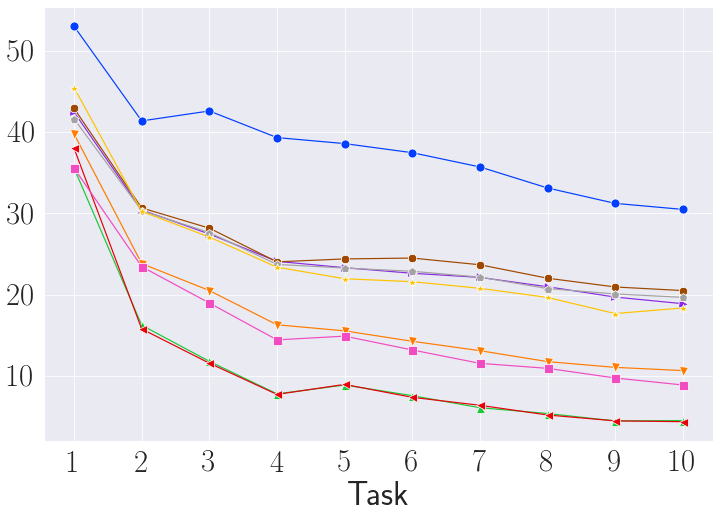

In [145]:
sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=3.5)
# cvpr_line('cifar10', '05k', 5)
#cvpr_line('cifar100', '2k', 10)
cvpr_line('mini_imagenet', '2k', 10)

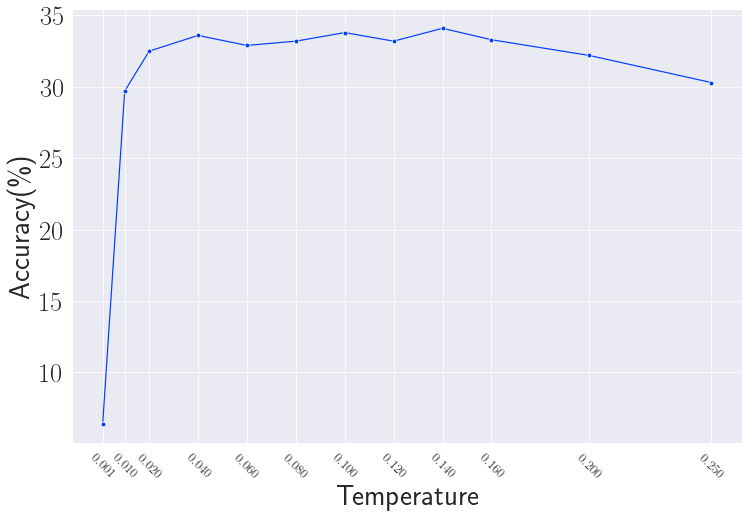

In [89]:
sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=3)
temperature_abl = {}
temperature_abl['Temperature'] = [0.001, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12,0.14,0.16, 0.2, 0.25]
temperature_abl['Accuracy(%)'] = [6.4, 29.7, 32.5, 33.6, 32.9, 33.2, 33.8, 33.2, 34.1, 33.3, 32.2, 30.3]
data_preproc = pd.DataFrame(temperature_abl)
plt.figure(figsize=(12, 8))
g = sns.lineplot(x='Temperature', y='Accuracy(%)',data=data_preproc, marker='o')
g.set_ylabel(r'Accuracy(\%)')
# g.set_ylim(31,36)
g.set(xticks=temperature_abl['Temperature'])
plt.xticks(rotation='315', fontsize=13)
g.figure.savefig('temperature_more.pdf', format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

Text(0, 0.5, 'Accuracy(\\%)')

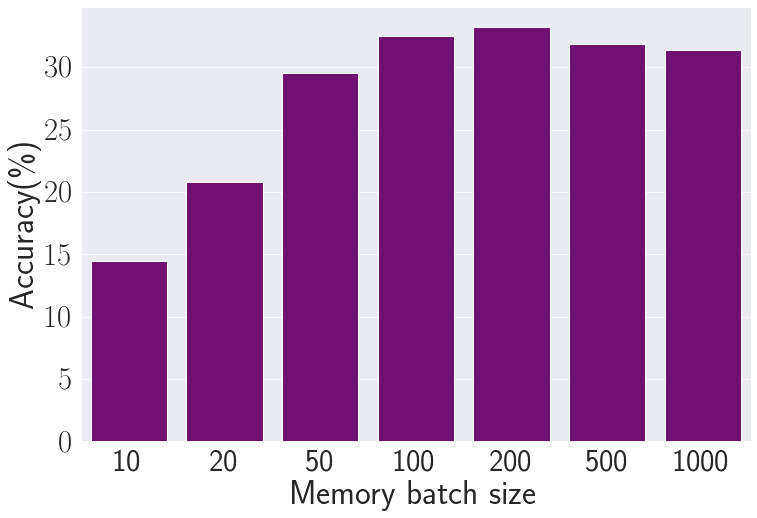

In [78]:
sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=3.5)

temperature_abl = {}
temperature_abl['Memory batch size'] = [10, 20, 50, 100, 200, 500, 1000]
temperature_abl['Accuracy(%)'] = [14.5, 20.8, 29.5, 32.5, 33.2, 31.9, 31.4]
data_preproc = pd.DataFrame(temperature_abl)
plt.figure(figsize=(12, 8))
g = sns.barplot(x='Memory batch size', y='Accuracy(%)',data=data_preproc,color='purple')
g.set_ylabel(r'Accuracy(\%)')
# g.set_ylim(10,36)
# plt.xticks([10, 20, 50, 100, 200, 500, 1000], rotation='315')

# g.figure.savefig('mbs.pdf', format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

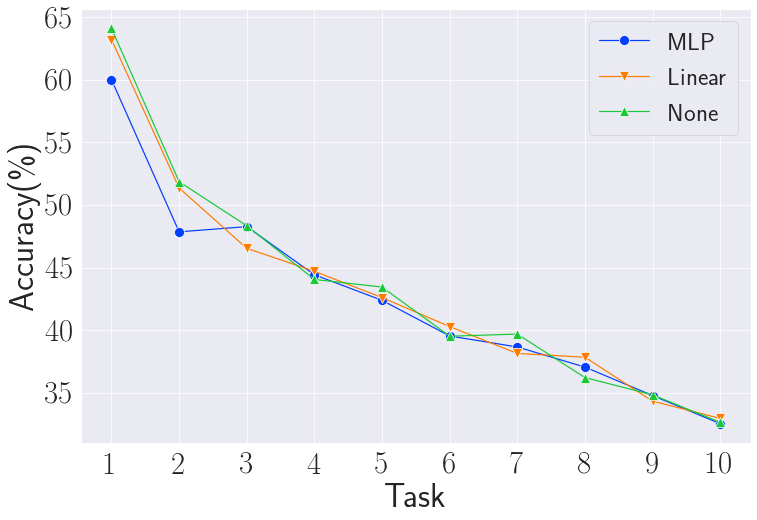

In [138]:
files = ['mlp.pkl', 'linear.pkl', 'None.pkl']
names = ['MLP', 'Linear', 'None']
sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=3.5)
tmp_dict = {}
x_data = []
acc_data = []
trick_data = []
mem_data = []
agent_data = []
file_path = 'result/{}/'.format('cifar100')


for idx, file in enumerate(files):
    acc = find_files_cvpr(file_path, file)
    avg_acc_mean_multiple_run = np.mean(avg_acc(acc), axis=0)*100
    n = avg_acc_mean_multiple_run.shape[0]
    x_data += [i for i in range(1, n+1)]
    acc_data += (avg_acc_mean_multiple_run.tolist())
    agent_data += [names[idx]]*n

tmp_dict['data'] = acc_data
tmp_dict['Method'] = agent_data
tmp_dict['Task'] = x_data
data_preproc = pd.DataFrame(tmp_dict)
plt.figure(figsize=(12, 8))
marker = Line2D.filled_markers[:len(set(agent_data))]
mpl.rcParams['lines.markersize'] = 10
g = sns.lineplot(x='Task', y='data',data=data_preproc, hue="Method",
                style='Method', dashes=False, legend=False, markers=marker)
g.set(xticks=[i for i in range(1, n+1)])
plt.legend(labels=names,fontsize=25, loc='upper right')
g.set_ylabel(r'Accuracy(\%)')
#g.set_ylabel('')
plt.show(g)
g.figure.savefig('projection.pdf', format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')

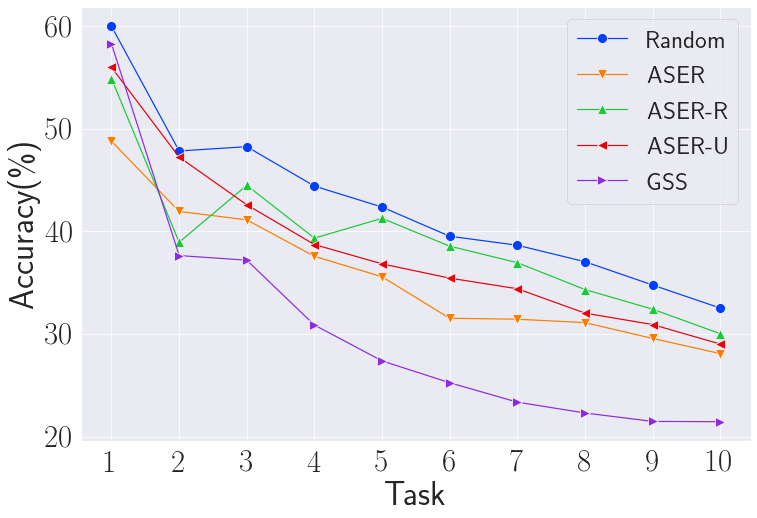

In [139]:
# agents = ['SCR', 'A-GEM', 'EWC', 'finetune', 'GSS', 'MIR', 'LWF', 'ER', 'ASER']
# agents_name = [r"\underline{SCR}", 'A-GEM', 'EWC++', 'Finetune','GSS', 'MIR', 'LwF', 'ER', r'ASER$_\mu$']
# no_m_agent = ['EWC', 'LWF', 'finetune']
sns.set_theme(context='paper', style='darkgrid', palette='bright', font_scale=3.5)

files = ['mlp.pkl', 'scr_aser.pkl', 'scr_aser_retrieve.pkl', 'scr_aser_update.pkl', 'scr_gss.pkl']
names = ['Random', 'ASER', 'ASER-R', 'ASER-U', 'GSS']
tmp_dict = {}
x_data = []
acc_data = []
trick_data = []
mem_data = []
agent_data = []
file_path = 'result/{}/'.format('cifar100')


for idx, file in enumerate(files):
    acc = find_files_cvpr(file_path, file)
    avg_acc_mean_multiple_run = np.mean(avg_acc(acc), axis=0)*100
    n = avg_acc_mean_multiple_run.shape[0]
    x_data += [i for i in range(1, n+1)]
    acc_data += (avg_acc_mean_multiple_run.tolist())
    agent_data += [names[idx]]*n

tmp_dict['data'] = acc_data
tmp_dict['Method'] = agent_data
tmp_dict['Task'] = x_data
data_preproc = pd.DataFrame(tmp_dict)
plt.figure(figsize=(12, 8))
marker = Line2D.filled_markers[:len(set(agent_data))]
mpl.rcParams['lines.markersize'] = 10
g = sns.lineplot(x='Task', y='data',data=data_preproc, hue="Method",
                style='Method', dashes=False, legend=False, markers=marker)
g.set(xticks=[i for i in range(1, n+1)])
plt.legend(labels=names,fontsize=25, loc='upper right')
g.set_ylabel(r'Accuracy(\%)')
#g.set_ylabel('')
plt.show(g)
g.figure.savefig('mem_management.pdf', format='pdf', pad_inches=0, dpi=250, bbox_inches='tight')